# Менеджер датасета

## Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from typing import Optional, Dict, Tuple, List
from pandas import DataFrame, Series
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

## Класс DatasetManager

In [2]:
class DatasetManager:
    def __init__(
        self,
        source: str = "sklearn",
        csv_path: Optional[str] = None,
    ) -> None:
        """
        Инициализирует менеджер датасета для загрузки, анализа, предобработки и визуализации.

        Параметры:
            source (str): Источник данных.
                - "sklearn": загружаем встроенный датасет Wine из sklearn.
                - "csv": читаем CSV-файл по пути csv_path.
            csv_path (Optional[str]): Путь к CSV-файлу при source="csv".
                Если source="sklearn", игнорируется.
        """
        self.source: str = source
        self.csv_path: Optional[str] = csv_path
        self.df: Optional[DataFrame] = None
        self.features: Optional[DataFrame] = None
        self.target: Optional[Series] = None
        self.scaled_features: Optional[DataFrame] = None
        self.stats: Dict[str, DataFrame] = {}

        self._load_data()
        self._extract_features_target()

    def _load_data(self) -> None:
        """
        Загружает исходный датасет в self.df.

        При source="sklearn" загружается Wine-датасет из sklearn.
        При source="csv" загружается CSV-файл по пути csv_path.

        Выбрасывает:
            ValueError: если source="csv" и csv_path не указан или source не равен "sklearn"/"csv".
        """
        if self.source == "sklearn":
            raw = load_wine(as_frame=True)
            df0 = raw.frame.copy()
            self.df = df0
        elif self.source == "csv":
            if self.csv_path is None:
                raise ValueError("При source='csv' необходимо указать путь csv_path")
            self.df = pd.read_csv(self.csv_path)
        else:
            raise ValueError("source должен быть 'sklearn' или 'csv'")

        print(
            f"Данные загружены: {self.df.shape[0]} строк, {self.df.shape[1]} столбцов"
        )

    def _extract_features_target(self) -> None:
        """
        Разделяет DataFrame на признаки и метку (если столбец 'target' присутствует).

        После выполнения:
            - self.features будет содержать DataFrame только с признаками.
            - self.target будет содержать Series с метками классов (или None, если 'target' отсутствует).
        """
        if self.df is None:
            raise RuntimeError("Данные не загружены. Сначала вызовите _load_data().")

        if "target" in self.df.columns:
            self.target = self.df["target"].copy()
            self.features = self.df.drop(columns=["target"]).copy()
        else:
            self.target = None
            self.features = self.df.copy()

    def compute_basic_statistics(self) -> Dict[str, DataFrame]:
        """
        Вычисляет базовые статистики по признакам и сохраняет их в self.stats.

        Сохраняются:
            - "describe": описательные статистики (mean, std, min, max, квартили) для каждого признака.
            - "correlation_matrix": матрица корреляций между признаками.
            - "class_distribution": распределение по классам (если есть self.target).

        Возвращает:
            Dict[str, DataFrame]: Словарь с DataFrame-статистиками.
        """
        if self.features is None:
            raise RuntimeError(
                "Признаки не выделены. Сначала вызовите _extract_features_target()."
            )

        desc = self.features.describe().T
        self.stats["describe"] = desc

        corr = self.features.corr()
        self.stats["correlation_matrix"] = corr

        if self.target is not None:
            class_counts: Series = self.target.value_counts().sort_index()
            self.stats["class_distribution"] = class_counts.to_frame(name="count")

        return self.stats

    def preprocess(
        self,
        drop_duplicates: bool = True,
        drop_outliers: bool = True,
        z_thresh: float = 3.0,
    ) -> None:
        """
        Полная предобработка данных:
            1. Удаление дубликатов.
            2. Удаление выбросов по Z-оценке (если drop_outliers=True).
            3. Масштабирование признаков StandardScaler.

        Параметры:
            drop_duplicates (bool): Удалять ли полные дубликаты строк (True/False).
            drop_outliers (bool): Удалять ли выбросы по Z-оценке (True/False).
            z_thresh (float): Порог Z-оценки; объекты, у которых хотя бы один признак
                              имеет |z_score| > z_thresh, считаются выбросами.

        После выполнения:
            - self.df обновляется без дубликатов и выбросов.
            - self.features обновляются (признаки из очищенного DataFrame).
            - self.target обновляется (метки из очищенного DataFrame).
            - self.scaled_features заполняется DataFrame-ом масштабированных признаков.
        """
        if self.df is None:
            raise RuntimeError("Данные не загружены. Сначала вызовите _load_data().")

        df_proc: DataFrame = self.df.copy()

        if drop_duplicates:
            before = df_proc.shape[0]
            df_proc = df_proc.drop_duplicates().reset_index(drop=True)
            after = df_proc.shape[0]
            print(f"Удалено дубликатов: {before - after}")

        if drop_outliers:
            df_no_target = df_proc.drop(columns=["target"], errors="ignore")
            means = df_no_target.mean()
            stds = df_no_target.std(ddof=0)
            z_scores = (df_no_target - means) / stds
            mask = (z_scores.abs() <= z_thresh).all(axis=1)
            before_out = df_proc.shape[0]
            df_proc = df_proc[mask].reset_index(drop=True)
            after_out = df_proc.shape[0]
            print(f"Удалено выбросов: {before_out - after_out}")

        scaler = StandardScaler()
        feat: DataFrame = df_proc.drop(columns=["target"], errors="ignore")
        scaled_array = scaler.fit_transform(feat)
        scaled_df = pd.DataFrame(scaled_array, columns=feat.columns, index=feat.index)

        self.df = df_proc
        if "target" in df_proc.columns:
            self.target = df_proc["target"].copy()
            self.features = df_proc.drop(columns=["target"]).copy()
        else:
            self.target = None
            self.features = df_proc.copy()

        self.scaled_features = scaled_df
        print(
            "Предобработка завершена: дубликаты и выбросы (если указано) удалены, признаки масштабированы."
        )

    def visualize_distributions(self, figsize: Tuple[int, int] = (12, 8)) -> None:
        """
        Строит гистограммы распределений каждого признака (до масштабирования).

        Параметры:
            figsize (Tuple[int, int]): Размер фигуры (ширина, высота) в дюймах.
        """
        if self.features is None:
            raise RuntimeError(
                "Признаки не выделены. Сначала вызовите _extract_features_target()."
            )

        n = len(self.features.columns)
        cols = 3
        rows = (n + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        axes = axes.flatten()

        for i, col in enumerate(self.features.columns):
            axes[i].hist(self.features[col], bins=15, edgecolor="black")
            axes[i].set_title(col)
        for j in range(n, len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()

    def visualize_scatter_matrix(
        self,
        with_target: bool = True,
        figsize: Tuple[int, int] = (10, 10),
    ) -> None:
        """
        Строит матрицу рассеяния (pairplot) для первых 5–7 признаков.

        Параметры:
            with_target (bool): Если True и self.target определён, раскрашивает точки по классам.
            figsize (Tuple[int, int]): Размер фигуры (ширина, высота) в дюймах.
        """
        if self.features is None:
            raise RuntimeError(
                "Признаки не выделены. Сначала вызовите _extract_features_target()."
            )

        num_to_plot = min(7, len(self.features.columns))
        df_plot = self.features.iloc[:, :num_to_plot].copy()

        if with_target and self.target is not None:
            df_plot["target"] = self.target.values
            colors = {0: "red", 1: "green", 2: "blue"}
            scatter_matrix(
                df_plot,
                figsize=figsize,
                diagonal="hist",
                color=df_plot["target"].map(colors),
                alpha=0.5,
            )
        else:
            scatter_matrix(df_plot, figsize=figsize, diagonal="hist", alpha=0.5)

        plt.suptitle("Матрица рассеяния признаков", y=1.02)
        plt.show()

    def visualize_correlation_heatmap(self, figsize: Tuple[int, int] = (12, 8)) -> None:
        """
        Строит «приятную» тепловую карту корреляций между признаками с помощью seaborn.

        Параметры:
            figsize (Tuple[int, int]): Размер фигуры (ширина, высота) в дюймах.
        """
        if self.features is None:
            raise RuntimeError(
                "Признаки не выделены. Сначала вызовите _extract_features_target()."
            )

        plt.figure(figsize=figsize)
        sns.heatmap(
            self.features.corr(),
            annot=True,
            cmap="coolwarm",
            linewidths=0.5,
            square=True,
            cbar_kws={"shrink": 0.7},
        )
        plt.title("Матрица корреляции признаков")
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def get_preprocessed_data(self) -> Tuple[DataFrame, Optional[Series]]:
        """
        Возвращает масштабированные признаки и метки (если есть) для дальнейшего анализа/кластеризации.

        Возвращает:
            Tuple[DataFrame, Optional[Series]]:
                - DataFrame: self.scaled_features (масштабированные признаки).
                - Series или None: self.target (метки классов, если были изначально).

        Выбрасывает:
            RuntimeError: если self.scaled_features ещё не вычислены (не вызван preprocess()).
        """
        if self.scaled_features is None:
            raise RuntimeError(
                "Данные ещё не предобработаны. Сначала вызовите preprocess()."
            )
        return self.scaled_features, self.target

    def visualize_class_distribution(
        self,
        figsize: Tuple[int, int] = (8, 8),
        title: str = "Распределение по классам",
        colors: Optional[List[str]] = None,
        autopct: str = "%1.1f%%",
        startangle: int = 90,
    ) -> None:
        """
        Строит круговую диаграмму распределения объектов по классам.

        Параметры:
            figsize (Tuple[int, int]): Размер фигуры (ширина, высота) в дюймах.
            title (str): Заголовок диаграммы.
            colors (Optional[List[str]]): Список цветов для секторов.
            autopct (str): Формат отображения процентных значений.
            startangle (int): Угол начала первой секции.
        """
        if "class_distribution" not in self.stats:
            raise RuntimeError(
                "Распределение по классам не вычислено. Вызовите compute_basic_statistics()."
            )

        class_dist = self.stats["class_distribution"]
        labels = class_dist.index.astype(str).tolist()
        sizes = class_dist["count"].tolist()

        if not colors:
            colors = ["#ff9999", "#66b3ff", "#99ff99", "#ffcc99"]

        plt.figure(figsize=figsize)
        plt.pie(
            sizes,
            labels=labels,
            colors=colors,
            autopct=autopct,
            startangle=startangle,
            textprops={"fontsize": 12},
            wedgeprops={"edgecolor": "black", "linewidth": 0.5},
        )
        plt.title(title, fontsize=14, pad=20)
        plt.axis("equal")
        plt.show()

    def remove_feature(self, feature_name: str) -> None:
        """
        Удаляет признак из текущего набора данных по его имени.

        Параметры:
            feature_name (str): Название удаляемого признака.

        Исключения:
            ValueError: если feature_name не является строкой.
            KeyError: если признака с таким именем нет в self.features.
            RuntimeError: если self.features ещё не инициализирован (нет данных).
        """
        if self.features is None:
            raise RuntimeError(
                "Набор признаков пуст. Сначала выполните загрузку данных и метод _extract_features_target()."
            )

        if not isinstance(feature_name, str):
            raise ValueError(
                f"Имя признака должно быть строкой, получено {type(feature_name).__name__}"
            )

        if feature_name not in self.features.columns:
            raise KeyError(
                f"Признак '{feature_name}' отсутствует в текущем наборе признаков."
            )

        self.features.drop(columns=[feature_name], inplace=True)

        if self.df is not None and feature_name in self.df.columns:
            self.df.drop(columns=[feature_name], inplace=True)

        if (
            self.scaled_features is not None
            and feature_name in self.scaled_features.columns
        ):
            self.scaled_features.drop(columns=[feature_name], inplace=True)

        print(f"Признак '{feature_name}' успешно удалён из набора данных.")

    def split_data(
        self, 
        test_size: float = 0.2, 
        random_state: int = 42,
        stratify: bool = True
    ) -> None:
        """
        Разделяет данные на обучающую и тестовую выборки.
        
        Параметры:
            test_size (float): Доля тестовых данных (по умолчанию 0.2).
            random_state (int): Seed для воспроизводимости.
            stratify (bool): Сохранять ли распределение классов (по умолчанию True).
        """
        if self.scaled_features is None or self.target is None:
            raise RuntimeError("Сначала выполните предобработку данных (preprocess())")
            
        stratify_param = self.target if stratify else None
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.scaled_features,
            self.target,
            test_size=test_size,
            random_state=random_state,
            stratify=stratify_param
        )
        
        print(f"Данные разделены:\n"
              f"- Обучающая выборка: {self.X_train.shape[0]} образцов\n"
              f"- Тестовая выборка: {self.X_test.shape[0]} образцов")
        
    def balance_classes(
        self, 
        sampler: str = "SMOTE", 
        random_state: int = 42
    ) -> None:
        """
        Балансирует классы с помощью выбранного метода.
        
        Параметры:
            sampler (str): Метод балансировки ('SMOTE' или 'undersampling').
            random_state (int): Seed для воспроизводимости.
        """
        if not hasattr(self, 'X_train'):
            raise RuntimeError("Сначала выполните разделение данных (split_data())")
            
        class_counts = self.y_train.value_counts()
        print("\nРаспределение классов до балансировки:")
        print(class_counts)

        if sampler == "SMOTE":
            sm = SMOTE(random_state=random_state)
            self.X_train, self.y_train = sm.fit_resample(self.X_train, self.y_train)
        elif sampler == "undersampling":
            min_class = class_counts.idxmin()
            min_count = class_counts.min()
            
            dfs = []
            for class_label in self.y_train.unique():
                class_df = self.X_train[self.y_train == class_label]
                dfs.append(class_df.sample(min_count, random_state=random_state))
                
            self.X_train = pd.concat(dfs)
            self.y_train = pd.Series([label for label, df in zip(self.y_train.unique(), dfs) 
                                    for _ in range(len(df))])
        else:
            raise ValueError("Доступные методы: 'SMOTE', 'undersampling'")

        print("\nРаспределение классов после балансировки:")
        print(self.y_train.value_counts())

    def get_training_data(self) -> Tuple[DataFrame, Series]:
        """Возвращает балансированные обучающие данные"""
        return self.X_train, self.y_train

    def get_testing_data(self) -> Tuple[DataFrame, Series]:
        """Возвращает тестовые данные"""
        return self.X_test, self.y_test

## Инициализация датасета

In [3]:
manager = DatasetManager(source="sklearn")
stats = manager.compute_basic_statistics()

Данные загружены: 178 строк, 14 столбцов


## Распределение объектов по классам

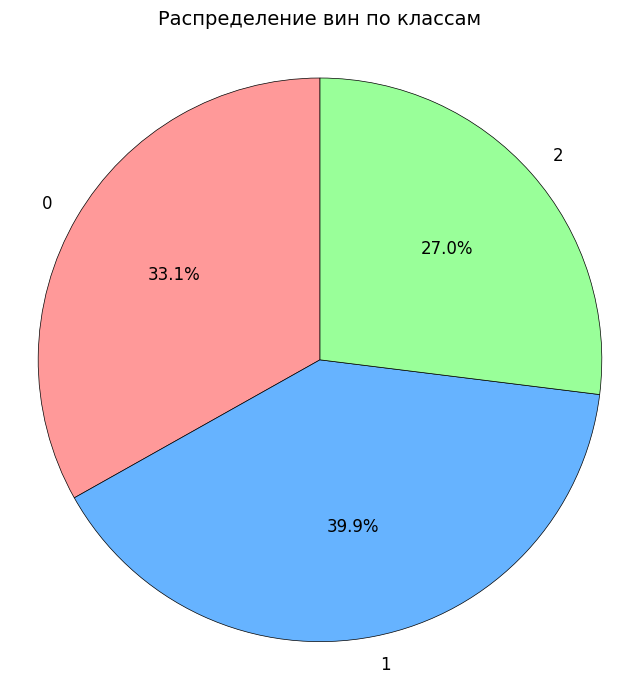

In [4]:
manager.visualize_class_distribution(
    title="Распределение вин по классам",
    colors=["#ff9999", "#66b3ff", "#99ff99"],
    autopct="%1.1f%%",
)

## Обзор признаков

In [5]:
print("Описание признаков:")
stats["describe"]

Описание признаков:


,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


## Распределения признаков

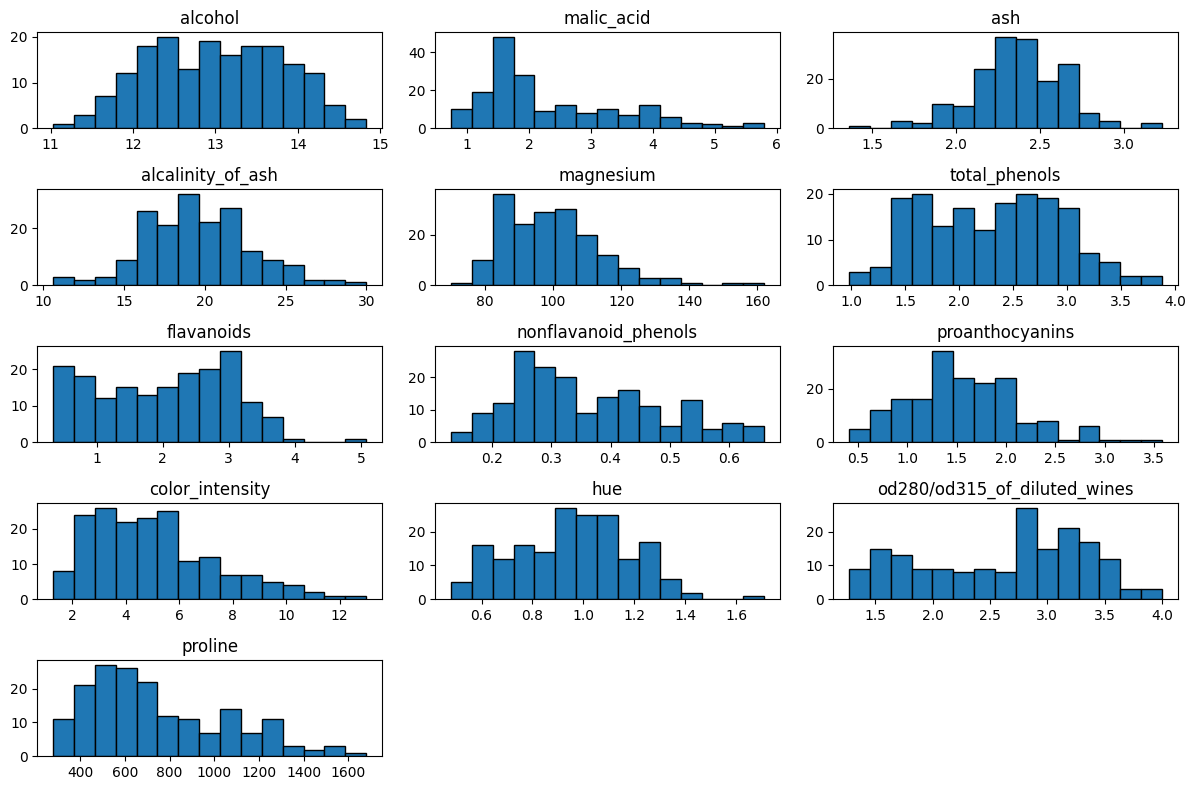

In [6]:
manager.visualize_distributions()

## Матрица рассеяния

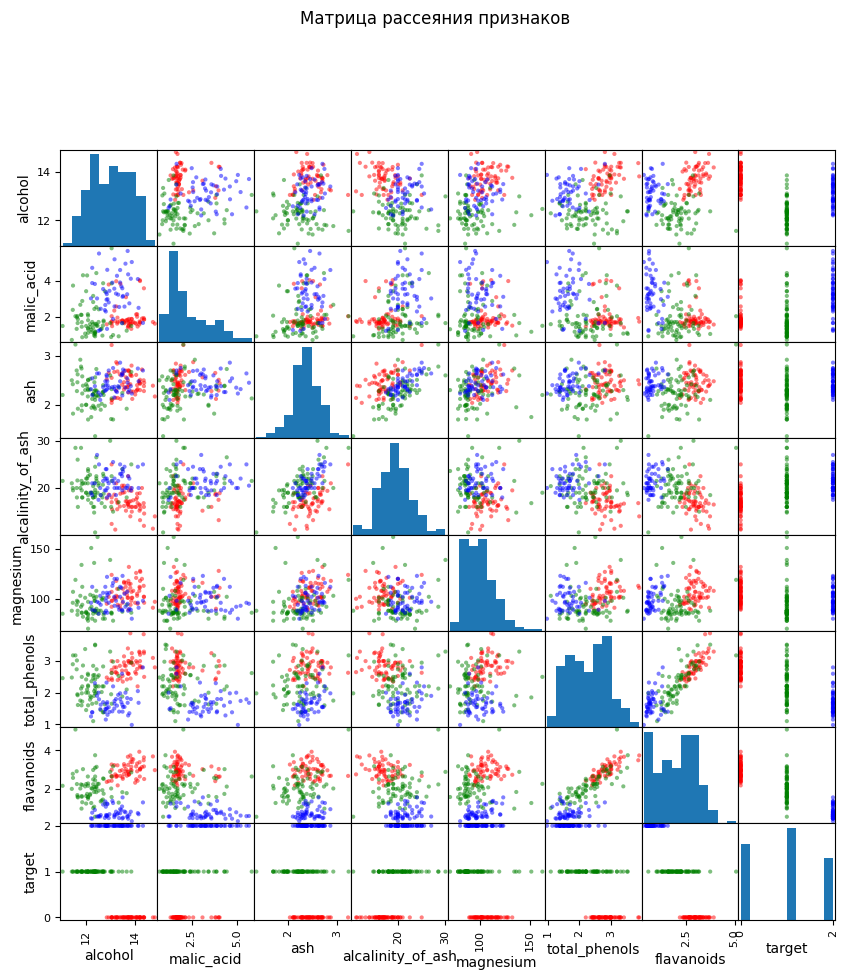

In [7]:
manager.visualize_scatter_matrix()

## Корреляции между признаками

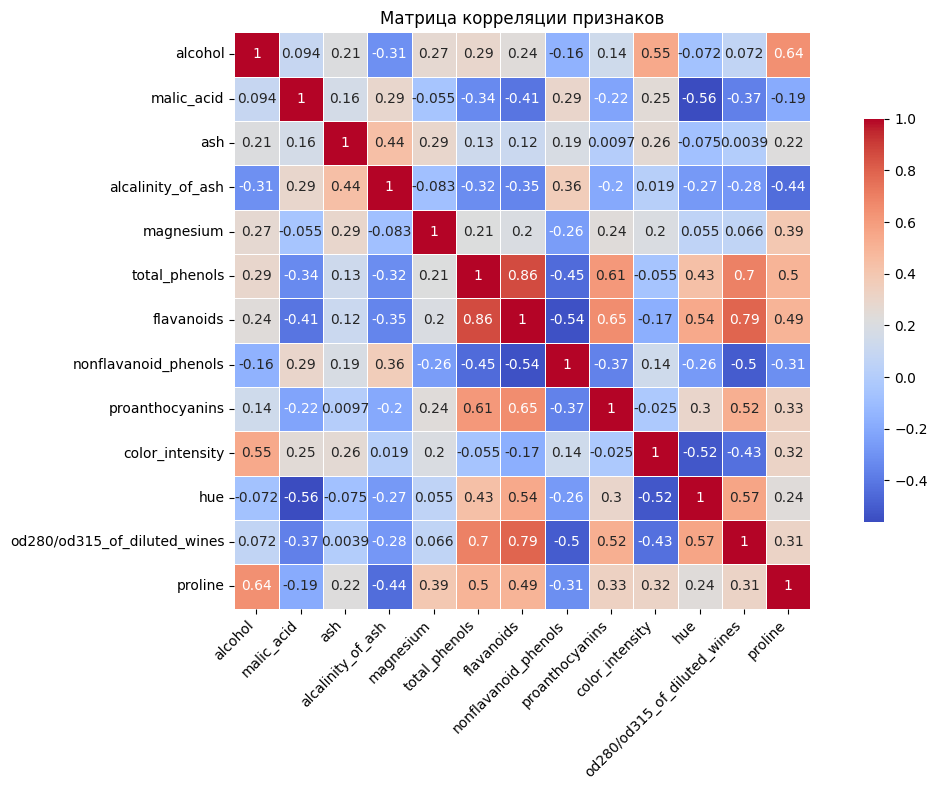

In [8]:
manager.visualize_correlation_heatmap()

## Предобработка данных

In [9]:
manager.preprocess()
manager.remove_feature("total_phenols")

Удалено дубликатов: 0
Удалено выбросов: 10
Предобработка завершена: дубликаты и выбросы (если указано) удалены, признаки масштабированы.
Признак 'total_phenols' успешно удалён из набора данных.


## Разделение данных на тестовую и обучающие выборки

In [10]:
manager.split_data(test_size=0.2, stratify=True)

Данные разделены:
- Обучающая выборка: 134 образцов
- Тестовая выборка: 34 образцов


## Обзор обучающей выборки

In [12]:
X_train, y_train = manager.get_training_data()
X_train

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
12,0.906497,-0.560569,0.168155,-1.081011,-0.780942,0.763248,-0.588156,0.486458,0.216077,0.904074,0.425828,1.781616
30,0.691503,-0.624523,-0.038050,-0.084038,0.576556,1.201017,-1.154635,0.751614,0.797321,0.631179,0.397757,2.394206
36,0.021228,-0.633659,0.745529,-0.437803,-0.062266,0.427285,-0.588156,-0.214312,-0.387523,0.767627,-0.121558,1.106196
31,0.817970,-0.469208,-0.038050,-0.695086,0.416851,0.691983,0.463877,0.789494,-0.570838,1.267935,0.383722,0.744925
95,-1.205501,-0.240803,-2.759954,-0.598605,-0.142119,0.162588,-0.830933,-0.290071,-0.812278,1.449865,0.510041,-0.134691
...,...,...,...,...,...,...,...,...,...,...,...,...
39,0.666210,-0.578842,-0.244255,-1.016690,1.454937,1.302824,-0.183528,1.490264,0.453046,-0.005577,1.099534,0.132335
131,-0.130532,0.426137,1.364143,0.527010,-0.221972,-1.537585,1.354059,-1.521154,-0.231034,-0.824263,-0.402269,-0.480255
155,0.881204,1.842244,-0.450459,1.009416,-0.860794,-1.568127,1.273133,-0.763564,0.672130,-0.778781,-1.188259,-0.731574
26,0.337396,-0.569705,-0.945351,-0.759407,-0.381677,0.182949,-0.750007,-0.384770,-0.521656,0.312801,0.243366,1.671664


In [13]:
y_train

12     0
30     0
36     0
31     0
95     1
      ..
39     0
131    2
155    2
26     0
157    2
Name: target, Length: 134, dtype: int64

## Обзор тестовой выборки

In [15]:
X_test, y_test = manager.get_testing_data()
X_test

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
74,-0.889334,-1.236646,-1.728930,-1.466936,2.972141,-0.163194,-0.102602,2.285733,-0.767567,0.494731,-0.402269,-0.009032
28,1.247958,-0.606250,-0.656664,-1.081011,-0.221972,0.325479,-0.830933,0.808434,-0.186323,0.403766,1.394280,0.886292
71,-1.736663,-0.423527,-1.852653,-1.081011,-0.142119,-0.448253,-0.183528,-0.763564,-0.588723,1.267935,-0.640873,-1.020591
14,1.703239,-0.432663,0.044432,-2.367428,0.257145,1.659147,-0.588156,2.664528,1.065588,1.131487,0.566184,2.494733
144,0.248869,0.873809,-0.367978,-0.277001,-0.062266,-1.201623,2.001464,0.600096,2.415864,-1.779397,-1.525112,-0.244643
129,0.577683,1.138758,-0.739146,0.044603,-0.860794,-1.557947,1.758687,-1.274937,0.260788,-0.642333,-1.090010,-0.543085
154,0.944437,0.380456,-0.285496,0.848614,-0.701089,-1.354333,0.382952,-0.990841,1.995579,-1.142641,-1.286508,-0.433133
97,-0.876687,0.097235,0.374360,0.527010,-0.062266,0.101504,-0.183528,-0.460529,-1.035834,-0.687816,1.099534,-0.989176
57,0.868557,-0.834654,0.539324,-0.855888,0.736262,1.689689,-1.397412,0.922072,0.752610,-0.278472,0.383722,1.671664
10,1.349132,-0.167714,-0.285496,-0.437803,0.496704,1.333366,-1.154635,1.566023,0.283144,1.358900,0.804788,2.378498


In [16]:
y_test

74     1
28     0
71     1
14     0
144    2
129    2
154    2
97     1
57     0
10     0
51     0
64     1
143    2
118    1
59     1
65     1
20     0
132    2
38     0
153    2
128    2
93     1
22     0
7      0
42     0
101    1
92     1
148    2
104    1
61     1
47     0
18     0
127    2
107    1
Name: target, dtype: int64

# KNN

In [17]:
import numpy as np
from typing import Union, Optional, Dict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

## Класс KNNClassifier

In [18]:
class KNNClassifier:
    def __init__(
        self, 
        n_neighbors: int = 5,
        weights: str = 'uniform',
        metric: str = 'minkowski'
    ) -> None:
        """
        Классификатор k-ближайших соседей (KNN).
        
        Параметры:
            n_neighbors (int): Количество соседей (по умолчанию 5).
            weights (str): Стратегия взвешивания:
                - 'uniform': все соседи имеют равный вес
                - 'distance': вес обратно пропорционален расстоянию (по умолчанию 'uniform').
            metric (str): Метрика для расчета расстояний (по умолчанию 'minkowski').
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
        self.model: Optional[KNeighborsClassifier] = None
        self.classes_: Optional[np.ndarray] = None

    def fit(
        self, 
        X_train: Union[pd.DataFrame, np.ndarray], 
        y_train: Union[pd.Series, np.ndarray]
    ) -> None:
        """
        Обучение модели на обучающих данных.
        
        Параметры:
            X_train (DataFrame/ndarray): Матрица признаков обучающей выборки.
            y_train (Series/ndarray): Вектор целевых меток.
        """
        self.model = KNeighborsClassifier(
            n_neighbors=self.n_neighbors,
            weights=self.weights,
            metric=self.metric
        )
        self.model.fit(X_train, y_train)
        self.classes_ = self.model.classes_

    def predict(
        self, 
        X_test: Union[pd.DataFrame, np.ndarray]
    ) -> np.ndarray:
        """
        Предсказание классов для новых данных.
        
        Параметры:
            X_test (DataFrame/ndarray): Матрица признаков тестовой выборки.
            
        Возвращает:
            ndarray: Массив предсказанных меток.
            
        Исключения:
            RuntimeError: Если модель не обучена.
        """
        if self.model is None:
            raise RuntimeError("Сначала выполните обучение модели (fit()).")
        return self.model.predict(X_test)

    def calculate_accuracy(
        self, 
        y_true: Union[pd.Series, np.ndarray], 
        y_pred: np.ndarray
    ) -> float:
        """
        Вычисление точности (Accuracy).
        
        Параметры:
            y_true (Series/ndarray): Истинные метки.
            y_pred (ndarray): Предсказанные метки.
            
        Возвращает:
            float: Значение метрики Accuracy ∈ [0, 1].
        """
        return accuracy_score(y_true, y_pred)

    def calculate_precision(
        self,
        y_true: Union[pd.Series, np.ndarray],
        y_pred: np.ndarray,
        average: str = 'macro'
    ) -> float:
        """
        Вычисление точности (Precision).
        
        Параметры:
            y_true (Series/ndarray): Истинные метки.
            y_pred (ndarray): Предсказанные метки.
            average (str): Стратегия усреднения:
                - 'macro': среднее по классам
                - 'micro': глобальное усреднение
                - 'weighted': взвешенное среднее
                
        Возвращает:
            float: Значение метрики Precision.
        """
        return precision_score(y_true, y_pred, average=average, zero_division=0)

    def calculate_recall(
        self,
        y_true: Union[pd.Series, np.ndarray],
        y_pred: np.ndarray,
        average: str = 'macro'
    ) -> float:
        """
        Вычисление полноты (Recall).

        Параметры:
            y_true (Series или ndarray): Истинные метки классов.
            y_pred (ndarray): Предсказанные моделью метки классов.
            average (str): Способ усреднения:
                - 'macro': среднее значение recall по всем классам;
                - 'micro': глобальная метрика по всем объектам;
                - 'weighted': среднее, взвешенное по количеству объектов в каждом классе.

        Возвращает:
            float: Значение метрики Recall в диапазоне [0, 1].
        """
        return recall_score(y_true, y_pred, average=average, zero_division=0)

    def calculate_f1(
        self,
        y_true: Union[pd.Series, np.ndarray],
        y_pred: np.ndarray,
        average: str = 'macro'
    ) -> float:
        """
        Вычисление F1-меры (F1-score).

        Параметры:
            y_true (Series или ndarray): Истинные метки классов.
            y_pred (ndarray): Предсказанные моделью метки классов.
            average (str): Способ усреднения:
                - 'macro': F1-score по каждому классу, затем среднее;
                - 'micro': общее число TP, FP и FN;
                - 'weighted': среднее, взвешенное по количеству объектов каждого класса.

        Возвращает:
            float: Значение метрики F1-score в диапазоне [0, 1].
        """
        return f1_score(y_true, y_pred, average=average, zero_division=0)

    def calculate_confusion_matrix(
        self,
        y_true: Union[pd.Series, np.ndarray],
        y_pred: np.ndarray
    ) -> np.ndarray:
        """
        Построение матрицы ошибок (confusion matrix), показывающей распределение предсказаний модели по классам.

        Параметры:
            y_true (Series или ndarray): Истинные метки классов.
            y_pred (ndarray): Предсказанные моделью метки классов.

        Возвращает:
            ndarray: Квадратная матрица размера [n_classes x n_classes], где
                    строки соответствуют истинным меткам, а столбцы — предсказанным.
        """
        return confusion_matrix(y_true, y_pred)

    def get_metrics_report(
        self,
        y_true: Union[pd.Series, np.ndarray],
        y_pred: np.ndarray,
        average: str = 'macro'
    ) -> Dict[str, float]:
        """
        Генерация сводного отчёта по основным метрикам классификации.

        Параметры:
            y_true (Series или ndarray): Истинные метки классов.
            y_pred (ndarray): Предсказанные моделью метки классов.
            average (str): Способ усреднения для precision, recall и F1:
                - 'macro': по всем классам одинаково,
                - 'micro': глобально по всем примерам,
                - 'weighted': с учётом долей классов в выборке.

        Возвращает:
            Dict[str, float]: Словарь, содержащий значения следующих метрик:
                - 'accuracy'
                - 'precision'
                - 'recall'
                - 'f1'
        """
        return {
            "accuracy": self.calculate_accuracy(y_true, y_pred),
            "precision": self.calculate_precision(y_true, y_pred, average),
            "recall": self.calculate_recall(y_true, y_pred, average),
            "f1": self.calculate_f1(y_true, y_pred, average)
        }

## Пример использования

In [19]:
knn = KNNClassifier(n_neighbors=3, weights='distance')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

## Метрики классификации

In [21]:
report = knn.get_metrics_report(y_test, y_pred)
print("Отчет о метриках классификации:")
for metric, value in report.items():
    print(f"- {metric}: {value:.4f}")

Отчет о метриках классификации:
- accuracy: 0.9412
- precision: 0.9524
- recall: 0.9487
- f1: 0.9466


## Матрица ошибок

In [22]:
print("Матрица ошибок:")
print(knn.calculate_confusion_matrix(y_test, y_pred))

Матрица ошибок:
[[12  0  0]
 [ 2 11  0]
 [ 0  0  9]]


## Класс KNNCustom

In [26]:
from collections import Counter

In [27]:
class KNNCustom:
    def __init__(
        self, n_neighbors: int = 5, weights: str = "uniform", metric: str = "euclidean"
    ) -> None:
        """
        Кастомная реализация классификатора k-ближайших соседей.

        Параметры:
            n_neighbors (int): Количество соседей (по умолчанию 5).
            weights (str): Стратегия взвешивания:
                - 'uniform': равные веса
                - 'distance': обратно пропорционально расстоянию
            metric (str): Метрика расстояния ('euclidean', 'manhattan', 'cosine')
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.metric = metric
        self.X_train: Optional[np.ndarray] = None
        self.y_train: Optional[np.ndarray] = None
        self.classes_: Optional[np.ndarray] = None

    def fit(
        self,
        X_train: Union[pd.DataFrame, np.ndarray],
        y_train: Union[pd.Series, np.ndarray],
    ) -> None:
        """
        Сохраняет обучающую выборку в памяти модели.

        Параметры:
            X_train (DataFrame или ndarray): Матрица признаков обучающих объектов.
            y_train (Series или ndarray): Вектор меток классов.
        """
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train)
        self.classes_ = np.unique(y_train)

    def _calculate_distance(self, a: np.ndarray, b: np.ndarray) -> float:
        """
        Вычисляет расстояние между двумя точками в заданной метрике.

        Параметры:
            a (ndarray): Первая точка.
            b (ndarray): Вторая точка.

        Возвращает:
            float: Расстояние между a и b в соответствии с выбранной метрикой ('euclidean', 'manhattan', 'cosine').

        Исключения:
            ValueError: Если указана неподдерживаемая метрика.
        """
        if self.metric == "euclidean":
            return np.sqrt(np.sum((a - b) ** 2))
        elif self.metric == "manhattan":
            return np.sum(np.abs(a - b))
        elif self.metric == "cosine":
            return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        else:
            raise ValueError(f"Unknown metric: {self.metric}")

    def predict(self, X_test: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        """
        Предсказывает метки классов для объектов тестовой выборки.

        Параметры:
            X_test (DataFrame или ndarray): Матрица признаков тестовых объектов.

        Возвращает:
            ndarray: Вектор предсказанных меток.

        Исключения:
            RuntimeError: Если модель не была обучена методом fit().
        """
        if self.X_train is None or self.y_train is None:
            raise RuntimeError("Модель не обучена. Вызовите fit() перед predict().")

        X_test = np.array(X_test)
        predictions = []

        for x in X_test:
            distances = [
                self._calculate_distance(x, x_train) for x_train in self.X_train
            ]

            k_indices = np.argsort(distances)[: self.n_neighbors]
            k_labels = self.y_train[k_indices]
            k_distances = np.array(distances)[k_indices]

            if self.weights == "distance":
                weights = 1 / (k_distances + 1e-8)
            else:
                weights = np.ones_like(k_distances)

            counter = Counter()
            for label, weight in zip(k_labels, weights):
                counter[label] += weight

            predictions.append(max(counter, key=counter.get))

        return np.array(predictions)

    def calculate_accuracy(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        Вычисляет точность (accuracy) классификации.

        Параметры:
            y_true (ndarray): Истинные метки.
            y_pred (ndarray): Предсказанные метки.

        Возвращает:
            float: Доля правильных ответов от общего числа наблюдений.
        """
        return np.sum(y_true == y_pred) / len(y_true)

    def calculate_confusion_matrix(
        self, y_true: np.ndarray, y_pred: np.ndarray
    ) -> np.ndarray:
        """
        Построение матрицы ошибок (confusion matrix).

        Параметры:
            y_true (ndarray): Истинные метки.
            y_pred (ndarray): Предсказанные метки.

        Возвращает:
            ndarray: Матрица размера [n_classes x n_classes], где строки — истинные классы,
                    столбцы — предсказанные классы.
        """
        n_classes = len(self.classes_)
        matrix = np.zeros((n_classes, n_classes), dtype=int)

        for true, pred in zip(y_true, y_pred):
            matrix[true, pred] += 1

        return matrix

    def _calculate_class_metrics(
        self, y_true: np.ndarray, y_pred: np.ndarray
    ) -> Dict[int, Dict[str, float]]:
        """
        Вычисляет метрики precision, recall и F1 для каждого класса отдельно.

        Параметры:
            y_true (ndarray): Истинные метки.
            y_pred (ndarray): Предсказанные метки.

        Возвращает:
            Dict[int, Dict[str, float]]: Словарь, в котором для каждого класса содержатся:
                - precision
                - recall
                - f1
                - support (количество наблюдений данного класса)
        """
        matrix = self.calculate_confusion_matrix(y_true, y_pred)
        metrics = {}

        for i, class_label in enumerate(self.classes_):
            tp = matrix[i, i]
            fp = np.sum(matrix[:, i]) - tp
            fn = np.sum(matrix[i, :]) - tp
            tn = np.sum(matrix) - tp - fp - fn

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = (
                2 * (precision * recall) / (precision + recall)
                if (precision + recall) > 0
                else 0
            )

            metrics[class_label] = {
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "support": tp + fn,
            }

        return metrics

    def calculate_precision(
        self, y_true: np.ndarray, y_pred: np.ndarray, average: str = "macro"
    ) -> float:
        """
        Вычисляет среднюю точность (precision) по классам.

        Параметры:
            y_true (ndarray): Истинные метки.
            y_pred (ndarray): Предсказанные метки.
            average (str): Метод усреднения:
                - 'macro': равное среднее по всем классам,
                - 'weighted': среднее с учетом поддержки (support),
                - 'micro': глобальная точность по всем классам.

        Возвращает:
            float: Значение метрики precision.
        """
        metrics = self._calculate_class_metrics(y_true, y_pred)
        precisions = [m["precision"] for m in metrics.values()]
        supports = [m["support"] for m in metrics.values()]

        if average == "macro":
            return np.mean(precisions)
        elif average == "weighted":
            return np.average(precisions, weights=supports)
        elif average == "micro":
            matrix = self.calculate_confusion_matrix(y_true, y_pred)
            tp = np.sum(np.diag(matrix))
            fp = np.sum(matrix, axis=0) - np.diag(matrix)
            return tp / (tp + np.sum(fp))
        else:
            raise ValueError("Неподдерживаемый тип усреднения")

    def calculate_recall(
        self, y_true: np.ndarray, y_pred: np.ndarray, average: str = "macro"
    ) -> float:
        """
        Вычисляет среднюю полноту (recall) по классам.

        Параметры:
            y_true (ndarray): Истинные метки.
            y_pred (ndarray): Предсказанные метки.
            average (str): Метод усреднения:
                - 'macro': равное среднее по всем классам,
                - 'weighted': среднее с учетом поддержки (support),
                - 'micro': глобальная полнота по всем классам.

        Возвращает:
            float: Значение метрики recall.
        """
        metrics = self._calculate_class_metrics(y_true, y_pred)
        recalls = [m["recall"] for m in metrics.values()]
        supports = [m["support"] for m in metrics.values()]

        if average == "macro":
            return np.mean(recalls)
        elif average == "weighted":
            return np.average(recalls, weights=supports)
        elif average == "micro":
            matrix = self.calculate_confusion_matrix(y_true, y_pred)
            tp = np.sum(np.diag(matrix))
            fn = np.sum(matrix, axis=1) - np.diag(matrix)
            return tp / (tp + np.sum(fn))
        else:
            raise ValueError("Неподдерживаемый тип усреднения")

    def calculate_f1(
        self, y_true: np.ndarray, y_pred: np.ndarray, average: str = "macro"
    ) -> float:
        """
        Вычисляет среднее значение F1-меры по классам.

        Параметры:
            y_true (ndarray): Истинные метки.
            y_pred (ndarray): Предсказанные метки.
            average (str): Метод усреднения ('macro', 'weighted', 'micro').

        Возвращает:
            float: Значение F1-меры.
        """
        precision = self.calculate_precision(y_true, y_pred, average)
        recall = self.calculate_recall(y_true, y_pred, average)
        return (
            2 * (precision * recall) / (precision + recall)
            if (precision + recall) > 0
            else 0
        )

    def get_metrics_report(
        self, y_true: np.ndarray, y_pred: np.ndarray, average: str = "macro"
    ) -> Dict[str, float]:
        """
        Генерирует сводный отчёт по метрикам классификации.

        Параметры:
            y_true (ndarray): Истинные метки.
            y_pred (ndarray): Предсказанные метки.
            average (str): Тип усреднения для precision, recall и F1 ('macro', 'weighted', 'micro').

        Возвращает:
            Dict[str, float]: Словарь с метриками:
                - 'accuracy'
                - 'precision'
                - 'recall'
                - 'f1'
        """
        return {
            "accuracy": self.calculate_accuracy(y_true, y_pred),
            "precision": self.calculate_precision(y_true, y_pred, average),
            "recall": self.calculate_recall(y_true, y_pred, average),
            "f1": self.calculate_f1(y_true, y_pred, average),
        }

## Пример использования

In [30]:
knn_custom = KNNCustom(n_neighbors=3, weights="distance", metric="euclidean")
knn_custom.fit(X_train.values, y_train.values)
y_pred = knn_custom.predict(X_test.values)

## Метрики классификации

In [31]:
report = knn.get_metrics_report(y_test.values, y_pred)
print("Отчет о метриках классификации:")
for metric, value in report.items():
    print(f"- {metric}: {value:.4f}")

Отчет о метриках классификации:
- accuracy: 0.9412
- precision: 0.9524
- recall: 0.9487
- f1: 0.9466


## Матрица ошибок

In [32]:
print("Матрица ошибок:")
print(knn.calculate_confusion_matrix(y_test.values, y_pred))

Матрица ошибок:
[[12  0  0]
 [ 2 11  0]
 [ 0  0  9]]
